# 使用Pandas开发向量化极速量化回测平台---股票版


## 可视化股票价格

In [40]:
import matplotlib.pyplot as plt

# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Populating the interactive namespace from numpy and matplotlib


### 加载数据

In [41]:

columns_def = [
            "Date","Open","High","Low","Close","Adj Close","Volume"
        ]

column_type = {
    'Date': np.str,
    'Open': np.float64,
    'High': np.float64,
    'Low': np.float64,
    'Close': np.float64,
    'Adj Close': np.float64,
    'Volume': np.float64,
}

filePath = r"D:\BackTraderCN\Class1\stock_data\000001.csv"

stock_code_daily = pd.read_csv(filePath,
                             dtype=column_type,
                             header=0)
                             
print(stock_code_daily)

#stock_code_daily = stock_code_daily[-700:]

            Date    Open    High     Low   Close  Adj Close     Volume
0     1992-01-02   0.561   0.564   0.554   0.556      0.556    11450.0
1     1992-01-03   0.365   0.367   0.362   0.364      0.364     2212.0
2     1992-01-06   0.364   0.372   0.363   0.371      0.371     2634.0
3     1992-01-07   0.371   0.377   0.369   0.374      0.374     2931.0
4     1992-01-08   0.372   0.377   0.369   0.371      0.371     1928.0
5     1992-01-09   0.371   0.372   0.366   0.371      0.371     1535.0
6     1992-01-10   0.371   0.372   0.369   0.372      0.372     1525.0
7     1992-01-13   0.372   0.372   0.370   0.371      0.371     1353.0
8     1992-01-14   0.371   0.371   0.362   0.365      0.365      711.0
9     1992-01-15   0.365   0.367   0.362   0.364      0.364     2205.0
10    1992-01-16   0.362   0.362   0.357   0.361      0.361     1268.0
11    1992-01-17   0.361   0.361   0.354   0.360      0.360     1143.0
12    1992-01-20   0.360   0.369   0.360   0.368      0.368     1085.0
13    

### 让时间称为索引 index

In [42]:
date_index = pd.DatetimeIndex(pd.to_datetime(stock_code_daily['Date'], format="%Y-%m-%d", errors='coerce'))
stock_code_daily.set_index(date_index, inplace= True)
stock_code_daily.index.set_names(['Date'], inplace=True)
stock_code_daily.dropna(inplace=True)

In [43]:
print(stock_code_daily.head())
print(stock_code_daily.tail())

                  Date   Open   High    Low  Close  Adj Close   Volume
Date                                                                  
1992-01-02  1992-01-02  0.561  0.564  0.554  0.556      0.556  11450.0
1992-01-03  1992-01-03  0.365  0.367  0.362  0.364      0.364   2212.0
1992-01-06  1992-01-06  0.364  0.372  0.363  0.371      0.371   2634.0
1992-01-07  1992-01-07  0.371  0.377  0.369  0.374      0.374   2931.0
1992-01-08  1992-01-08  0.372  0.377  0.369  0.371      0.371   1928.0
                  Date   Open   High    Low  Close  Adj Close     Volume
Date                                                                    
2019-07-25  2019-07-25  13.92  14.27  13.85  14.20      14.20  1087826.0
2019-07-26  2019-07-26  14.18  14.25  14.08  14.23      14.23   635305.0
2019-07-29  2019-07-29  14.25  14.45  14.18  14.29      14.29   715576.0
2019-07-30  2019-07-30  14.31  14.55  14.29  14.37      14.37   796634.0
2019-07-31  2019-07-31  14.30  14.32  14.08  14.13      14.13   6

### k线绘制函数

In [53]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
    
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
    
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]

    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
                               
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
            
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')


    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
    
    ax.grid(True)
    
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "red", colordown = "green", width = stick * .4)
    
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()



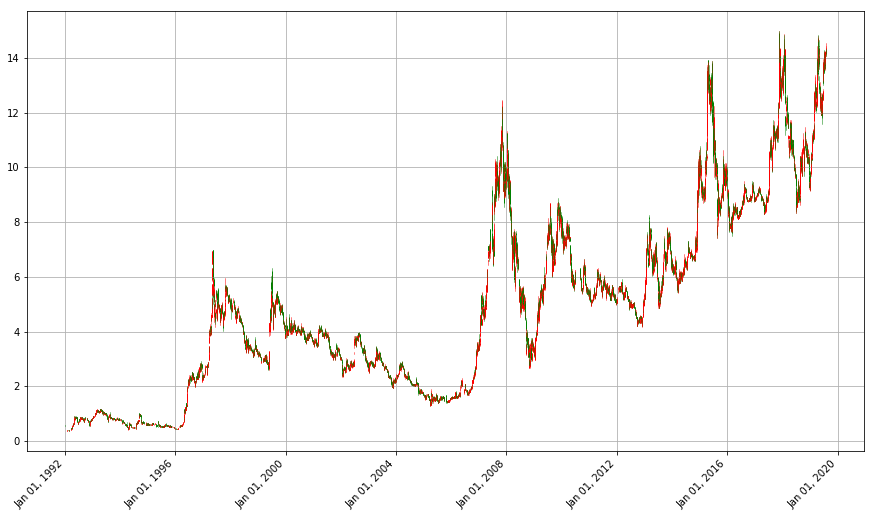

In [54]:
pandas_candlestick_ohlc(stock_code_daily)



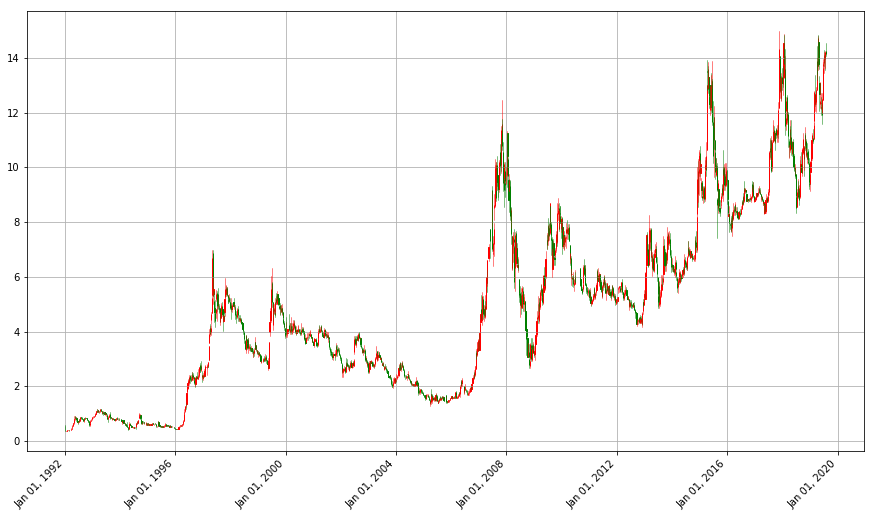

In [55]:
pandas_candlestick_ohlc(stock_code_daily, stick="week")

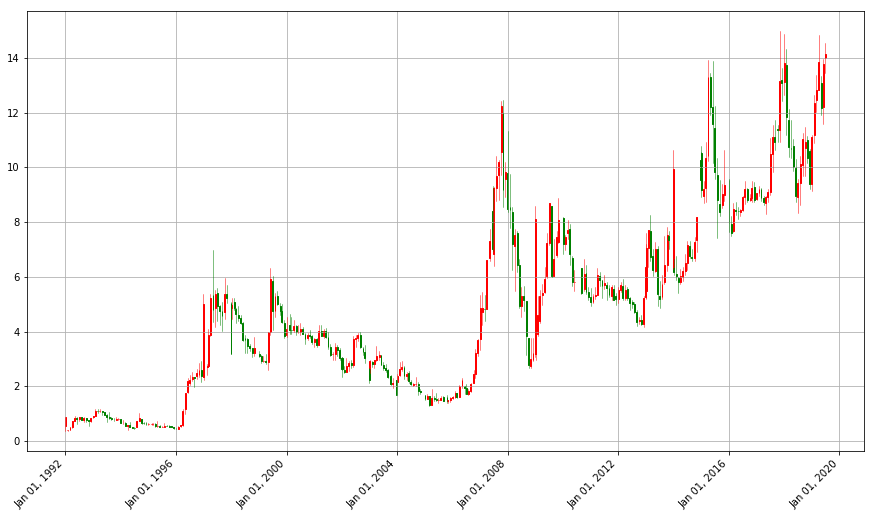

In [56]:
pandas_candlestick_ohlc(stock_code_daily, stick="month")

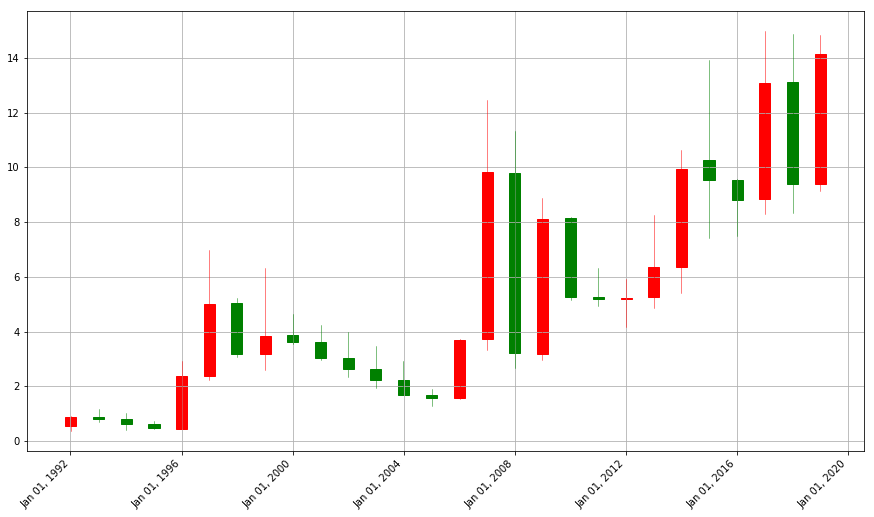

In [57]:
pandas_candlestick_ohlc(stock_code_daily, stick="year")

### 这种图有什么问题
虽然绝对价格很重要（高价股票难以购买，这不仅影响其波动性，而且影响您交易该股票的能力），在交易时，我们更关注资产的相对变化而不是绝对价格。 某一只股票比另一只股票贵得多，而且这种差异使得股票波动性远低于它们的实际价值（也就是说，它们的价格似乎并没有太大偏差）。

900元的股票波动1元，和10元的股票波动一元，他们的波动率是不同的


解决方案是绘制我们实际需要的信息：股票的回报。 这涉及将数据转换为对我们的目的更有用的东西。 我们可以应用多种转换。

一个转变是考虑自利息期开始以来股票的回报。 换句话说，我们绘制：

\begin{equation*}
\text{return}_{t,0} = \frac{\text{price}_t}{\text{price}_0}
\end{equation*}



In [58]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stocks_close = stock_code_daily["Close"]
x_0 = stock_code_daily["Close"].iloc[0]
stock_return = stocks_close.apply(lambda x: x / x_0)
print(stock_return.head())
print(stock_return.tail())

Date
1992-01-02    1.000000
1992-01-03    0.654676
1992-01-06    0.667266
1992-01-07    0.672662
1992-01-08    0.667266
Name: Close, dtype: float64
Date
2019-07-25    25.539568
2019-07-26    25.593525
2019-07-29    25.701439
2019-07-30    25.845324
2019-07-31    25.413669
Name: Close, dtype: float64


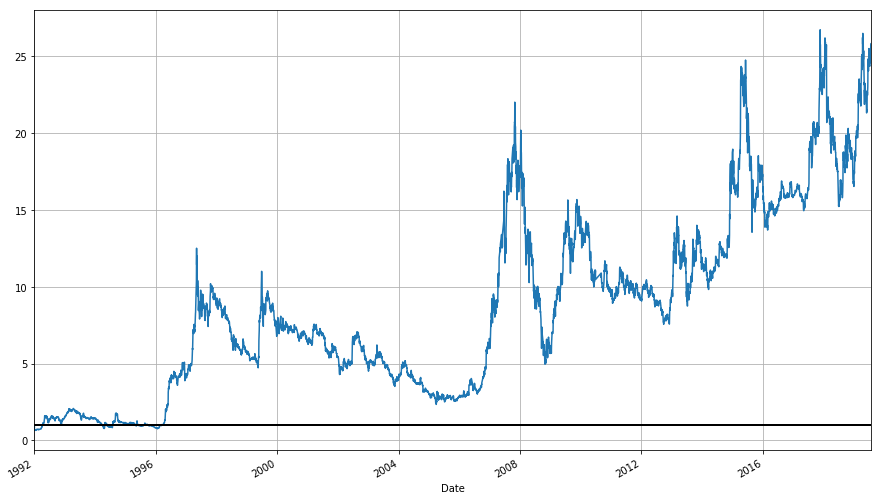

In [59]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

### 或者，我们可以绘制每天的变化。 一种方法是在比较日  $t$  和日  $t + 1$ 时绘制股票的百分比增长，公式如下：


\begin{equation*}
\text{growth}_t = \frac{\text{price}_{t + 1} - \text{price}_t}{\text{price}_t}
\end{equation*}

改变一下:

\begin{equation*}
\text{increase}_t = \frac{\text{price}_{t} - \text{price}_{t-1}}{\text{price}_t}
\end{equation*}

这些公式不一样，可能导致不同的结论，但还有另一种方法来模拟股票的增长：具有对数差异。

\begin{equation*}
\text{change}_t = \log(\text{price}_{t}) - \log(\text{price}_{t - 1})
\end{equation*}




这里， $\log$ 是自然对数，我们的定义并不强烈依赖于我们是否使用 $\log(\text{price}_{t}) - \log(\text{price}_{t - 1})$ 或者 $\log(\text{price}_{t+1}) - \log(\text{price}_{t})$.)  使用对数差异的优点是，这种差异可以解释为股票的百分比变化，但不依赖于分母的大小。 此外，对数差异具有理想的性质：对数差异的总和可以解释为总和的总变化（以百分比表示）（这不是其他表述的属性;它们会高估增长）。 对数差异也更清晰地对应于股票价格在连续时间内的建模方式。

我们做如下改变：


In [60]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
stock_change = np.log(stocks_close) - np.log(stocks_close.shift(1)) # shift moves dates back by 1.
print(stock_change.head())
print(stock_change.tail())

Date
1992-01-02         NaN
1992-01-03   -0.423614
1992-01-06    0.019048
1992-01-07    0.008054
1992-01-08   -0.008054
Name: Close, dtype: float64
Date
2019-07-25    0.022793
2019-07-26    0.002110
2019-07-29    0.004208
2019-07-30    0.005583
2019-07-31   -0.016843
Name: Close, dtype: float64


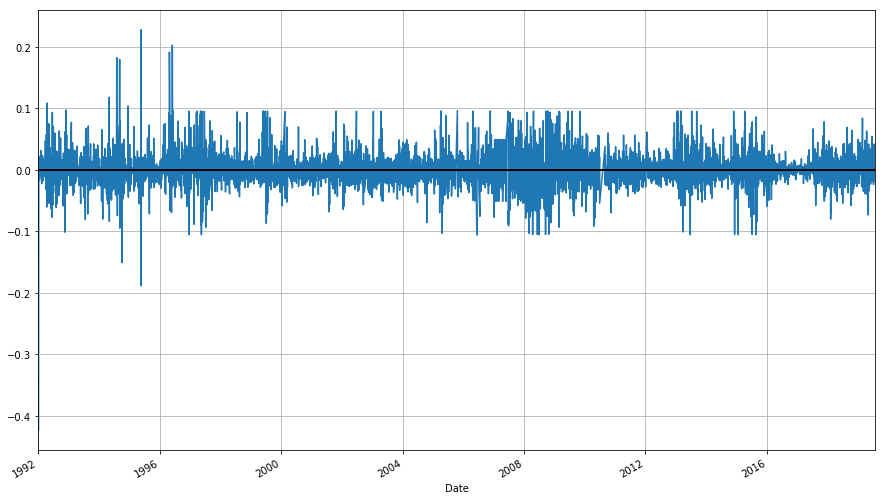

In [61]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

### 你更喜欢哪种转型？ 从期初开始看回报，使得证券的总体趋势更加明显。 但是，天数之间的变化是在对股票行为进行建模时实际考虑的更高级方法。 所以他们不应该被忽视。


## 双均线策略


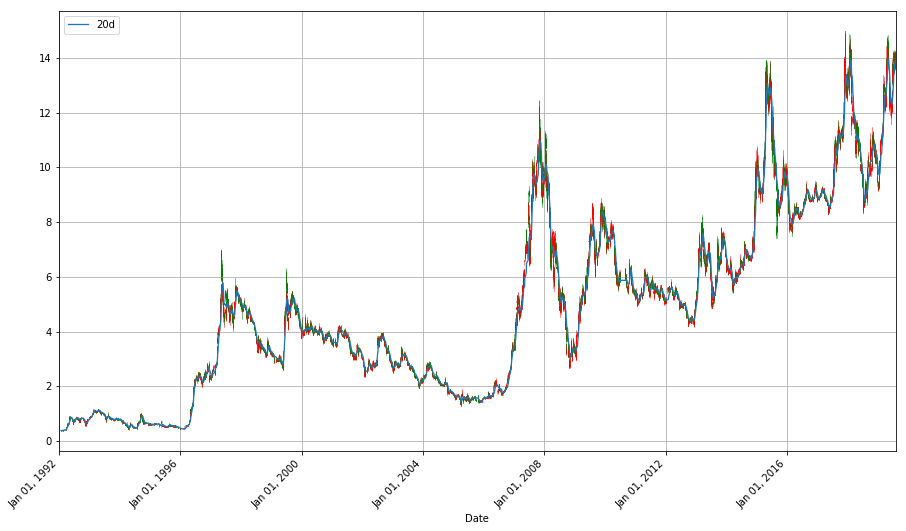

In [65]:
stock_code_daily["20d"] = np.round(stock_code_daily["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(stock_code_daily, otherseries = "20d")

In [66]:

stock_code_daily["50d"] = np.round(stock_code_daily["Close"].rolling(window = 50, center = False).mean(), 2)
stock_code_daily["200d"] = np.round(stock_code_daily["Close"].rolling(window = 200, center = False).mean(), 2)

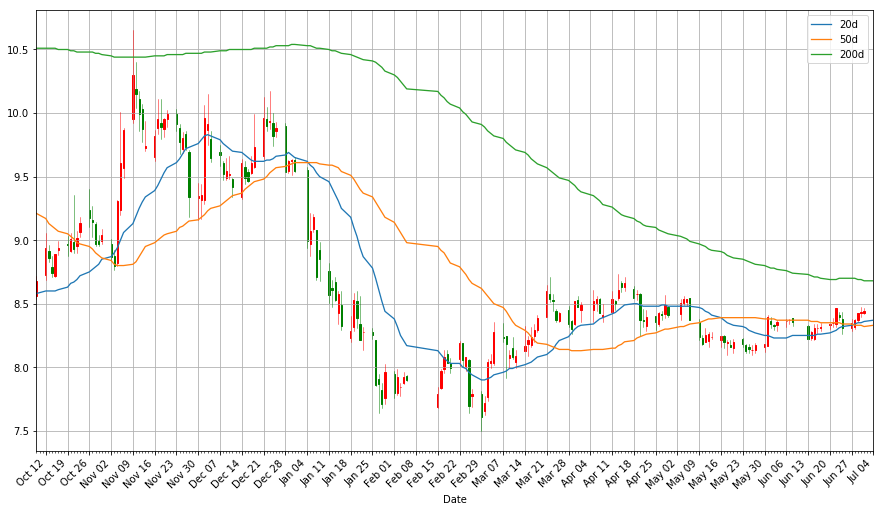

                  Date    Open    High     Low   Close  Adj Close     Volume  \
Date                                                                           
2015-10-09  2015-10-09   8.558   8.717   8.534   8.677      8.677   474612.0   
2015-10-12  2015-10-12   8.725   9.059   8.685   8.940      8.940   849665.0   
2015-10-13  2015-10-13   8.916   8.964   8.828   8.860      8.860   359798.0   
2015-10-14  2015-10-14   8.788   8.876   8.709   8.741      8.741   418980.0   
2015-10-15  2015-10-15   8.717   8.892   8.709   8.892      8.892   485900.0   
2015-10-16  2015-10-16   8.924   8.995   8.884   8.940      8.940   570001.0   
2015-10-19  2015-10-19   8.972   9.035   8.876   8.964      8.964   723371.0   
2015-10-20  2015-10-20   8.916   9.059   8.908   9.011      9.011   715163.0   
2015-10-21  2015-10-21   8.987   9.354   8.900   8.932      8.932  1332629.0   
2015-10-22  2015-10-22   8.956   9.075   8.900   9.019      9.019   822805.0   
2015-10-23  2015-10-23   9.067   9.179  

In [69]:
pandas_candlestick_ohlc(stock_code_daily.loc['2015-10-09':'2016-07-04',:], otherseries = ["20d", "50d", "200d"])


#少部分数据做测试
stock_code_daily_test = stock_code_daily['2015-10-09':'2016-07-04']
print(stock_code_daily_test)


### 交易策略

我们现在关注的是设计和评估交易策略。

任何交易者都必须有一套规则来确定她愿意在任何单笔交易中下注多少钱。例如，交易者可以决定在任何情况下她都不会在交易中冒10％以上的投资组合风险。此外，在任何交易中，交易者必须有一个**退出策略**，一套决定何时退出头寸的条件，无论是盈利还是亏损。交易者可以设定**目标**，这是促使交易者离开头寸的最小利润。同样，交易者可能会承受她愿意承受的最大损失;如果潜在损失超过此金额，交易者将退出该头寸以防止任何进一步的损失。我们假设任何特定交易所涉及的投资组合中的金额是固定比例; 10％似乎是一个很好的数字。

在这里，我将展示[移动平均线交叉策略]

*当快速移动平均线越过缓慢移动平均线时，交易资产。
*当快速移动平均线再次超过慢速移动平均线时退出交易。

当快速移动平均线从低于低于移动平均线时，交易将被进入，当快速移动平均线稍后低于慢移动平均线时，交易将被退出。

我们现在有一个完整的战略。但在我们决定使用它之前，我们应该首先尝试评估策略的质量。这样做的通常方法是**回测**，即查看策略对历史数据的盈利情况。例如，看看上面的图表在股票上的表现，如果20天移动平均线是快速移动平均线而50天移动平均线是缓慢的，那么这种策略似乎并不是非常有利可图，至少如果你不是总是采取多头头寸。

让我们看看我们是否可以自动执行回测测试任务。我们首先确定20天平均值何时低于50天平均值，反之亦然。



In [70]:
stock_code_daily_test['20d-50d'] = stock_code_daily_test['20d'] - stock_code_daily_test['50d']
print(stock_code_daily_test['20d-50d'])


Date
2015-10-09   -0.63
2015-10-12   -0.57
2015-10-13   -0.53
2015-10-14   -0.51
2015-10-15   -0.49
2015-10-16   -0.46
2015-10-19   -0.42
2015-10-20   -0.37
2015-10-21   -0.34
2015-10-22   -0.29
2015-10-23   -0.25
2015-10-26   -0.20
2015-10-27   -0.16
2015-10-28   -0.11
2015-10-29   -0.07
2015-10-30   -0.01
2015-11-02    0.03
2015-11-03    0.09
2015-11-04    0.14
2015-11-05    0.20
2015-11-06    0.26
2015-11-09    0.32
2015-11-10    0.36
2015-11-11    0.38
2015-11-12    0.39
2015-11-13    0.39
2015-11-16    0.41
2015-11-17    0.43
2015-11-18    0.46
2015-11-19    0.49
              ... 
2016-05-20   -0.06
2016-05-23   -0.07
2016-05-24   -0.08
2016-05-25   -0.10
2016-05-26   -0.11
2016-05-27   -0.12
2016-05-30   -0.13
2016-05-31   -0.13
2016-06-01   -0.14
2016-06-02   -0.15
2016-06-03   -0.14
2016-06-06   -0.14
2016-06-07   -0.13
2016-06-08   -0.12
2016-06-13   -0.12
2016-06-14   -0.11
2016-06-15   -0.11
2016-06-16   -0.10
2016-06-17   -0.09
2016-06-20   -0.08
2016-06-21   -0.07
2016-06

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [71]:
fast_ma_sr = stock_code_daily_test['20d']
slow_ma_sr = stock_code_daily_test['50d']


### 信号 signals

根据条件生成信号。

1.每当快速EMA超过慢速EMA时变长，而当相反发生时变短。

In [72]:
ma_entries = np.where(fast_ma_sr > slow_ma_sr, 1, 0)
ma_exits = np.where(fast_ma_sr < slow_ma_sr, 1, 0)

In [73]:
print(ma_entries)
print(ma_exits)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]


入口和出口向量都是0和1（位向量）的序列，以允许快速向量操作。

我们减少两个向量以仅包含其序列中第一个的信号，因为我们正在寻找交叉。

In [80]:
#连续出现1时候，只保留第一个1， 0视为分隔符
def first(v):
    """
        0 1 1 1 1 0
    =   0 1 0 0 0 0
    """
    #roll函数解释：沿着给定轴滚动数组元素。超出最后位置的元素将会滚动到第一个位置。
    rolled = np.roll(v, 1)
    #print(rolled)
    #第一个强制为0
    rolled[0] = 0
    #print(v - rolled == 1)
    return (v - rolled == 1).astype(int)

#连续出现1时候，只保留最后一个1， 0视为分隔符
def last(v):
    """
        0 1 1 1 1 0
    =   0 0 0 0 1 0
    """
    rolled = np.roll(v, -1)
    #print(rolled)
    rolled[-1] = 0
    return (v - rolled == 1).astype(int)



In [123]:
v = np.array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1])
print(v)
print(first(v))


[0 1 1 1 1 0 0 1 1 1 1 0 1 1 1]
[0 1 0 0 0 0 0 1 0 0 0 0 1 0 0]


In [82]:
v = np.array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1])
print(v)
print(last(v))

[0 1 1 1 1 0 0 1 1 1 1 0 1 1 1]
[0 0 0 0 1 0 0 0 0 0 1 0 0 0 1]


In [83]:
ma_entries =first(ma_entries)
print("ma_entries:", ma_entries)
ma_exits = first(ma_exits)
print("ma_exits:", ma_exits)

ma_entries: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
ma_exits: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


价格下跌10％时卖空。

In [84]:
rate_sr = stock_code_daily_test['Close']
rate_sr

Date
2015-10-09     8.677
2015-10-12     8.940
2015-10-13     8.860
2015-10-14     8.741
2015-10-15     8.892
2015-10-16     8.940
2015-10-19     8.964
2015-10-20     9.011
2015-10-21     8.932
2015-10-22     9.019
2015-10-23     9.131
2015-10-26     9.171
2015-10-27     9.139
2015-10-28     8.972
2015-10-29     8.972
2015-10-30     9.043
2015-11-02     8.868
2015-11-03     8.796
2015-11-04     9.306
2015-11-05     9.608
2015-11-06     9.863
2015-11-09    10.301
2015-11-10    10.150
2015-11-11     9.991
2015-11-12     9.871
2015-11-13     9.744
2015-11-16     9.823
2015-11-17     9.951
2015-11-18     9.887
2015-11-19     9.951
               ...  
2016-05-20     8.199
2016-05-23     8.183
2016-05-24     8.128
2016-05-25     8.144
2016-05-26     8.136
2016-05-27     8.176
2016-05-30     8.183
2016-05-31     8.398
2016-06-01     8.343
2016-06-02     8.327
2016-06-03     8.359
2016-06-06     8.367
2016-06-07     8.375
2016-06-08     8.359
2016-06-13     8.223
2016-06-14     8.279
2016-06-

In [85]:

v = np.zeros(6, dtype=int)
idx=[1,3,5]
v[idx] = 1
print(v)

[0 1 0 1 0 1]


In [86]:
# 将idx 指示的位置设置为1，其他为0
def from_idx(n, idx):
    """
    n = 6
    set_idx = 1, 3, 5
    =   0 1 0 1 0 1
    """
    v = np.zeros(n, dtype=int)
    v[idx] = 1
    return v


In [87]:
v = from_idx(6, [1,3,5])
print(v)


[0 1 0 1 0 1]


### 按百分比的跟踪止损

### 取价格出现的最大值好和最小值

In [92]:
rollmax_sr = rate_sr.rolling(window=len(rate_sr.index), min_periods=1).max()
rollmin_sr = rate_sr.rolling(window=len(rate_sr.index), min_periods=1).min()
print(len(rate_sr.index))
print(rollmax_sr)

182
Date
2015-10-09     8.677
2015-10-12     8.940
2015-10-13     8.940
2015-10-14     8.940
2015-10-15     8.940
2015-10-16     8.940
2015-10-19     8.964
2015-10-20     9.011
2015-10-21     9.011
2015-10-22     9.019
2015-10-23     9.131
2015-10-26     9.171
2015-10-27     9.171
2015-10-28     9.171
2015-10-29     9.171
2015-10-30     9.171
2015-11-02     9.171
2015-11-03     9.171
2015-11-04     9.306
2015-11-05     9.608
2015-11-06     9.863
2015-11-09    10.301
2015-11-10    10.301
2015-11-11    10.301
2015-11-12    10.301
2015-11-13    10.301
2015-11-16    10.301
2015-11-17    10.301
2015-11-18    10.301
2015-11-19    10.301
               ...  
2016-05-20    10.301
2016-05-23    10.301
2016-05-24    10.301
2016-05-25    10.301
2016-05-26    10.301
2016-05-27    10.301
2016-05-30    10.301
2016-05-31    10.301
2016-06-01    10.301
2016-06-02    10.301
2016-06-03    10.301
2016-06-06    10.301
2016-06-07    10.301
2016-06-08    10.301
2016-06-13    10.301
2016-06-14    10.301
2016

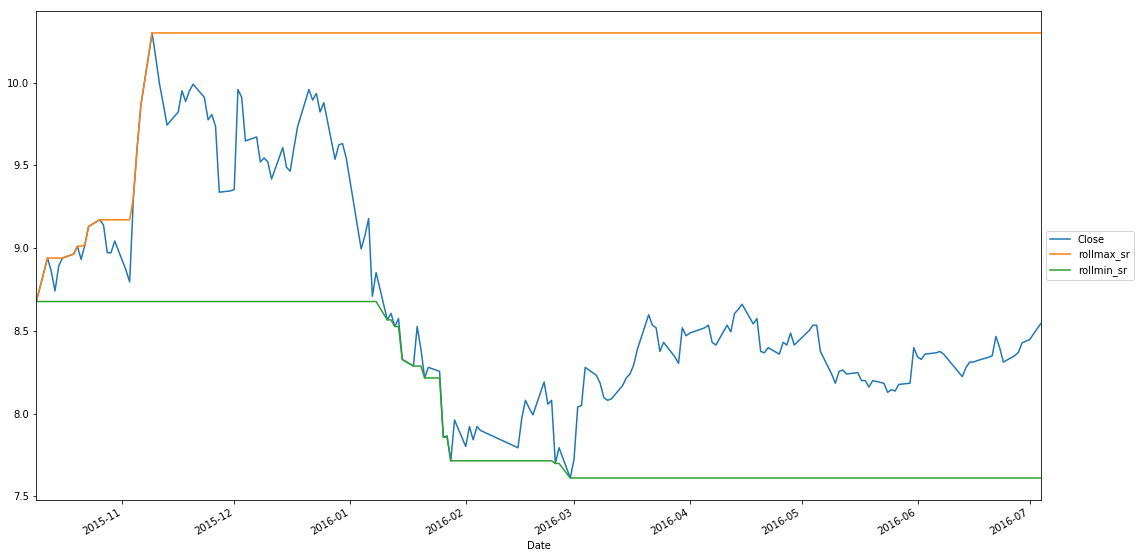

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10), sharex=True)
rate_sr.plot(ax=ax, ls='-', label='Close')
rollmax_sr.plot(ax=ax, ls='-', label='rollmax_sr')

rollmin_sr.plot(ax=ax, ls='-', label='rollmin_sr')

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

plt.show()

In [96]:
#nonzero(a)的用法：返回数组a中非零元素的索引值数组。
rollmax_sr.pct_change().nonzero()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  from ipykernel import kernelapp as app


(array([ 0,  1,  6,  7,  9, 10, 11, 18, 19, 20, 21], dtype=int64),)

In [100]:
#每次最高价格出现变动的位置和价格
changing_max_sr = rollmax_sr.iloc[rollmax_sr.pct_change().nonzero()]
changing_max_sr

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  from ipykernel import kernelapp as app


Date
2015-10-09     8.677
2015-10-12     8.940
2015-10-19     8.964
2015-10-20     9.011
2015-10-22     9.019
2015-10-23     9.131
2015-10-26     9.171
2015-11-04     9.306
2015-11-05     9.608
2015-11-06     9.863
2015-11-09    10.301
Name: Close, dtype: float64

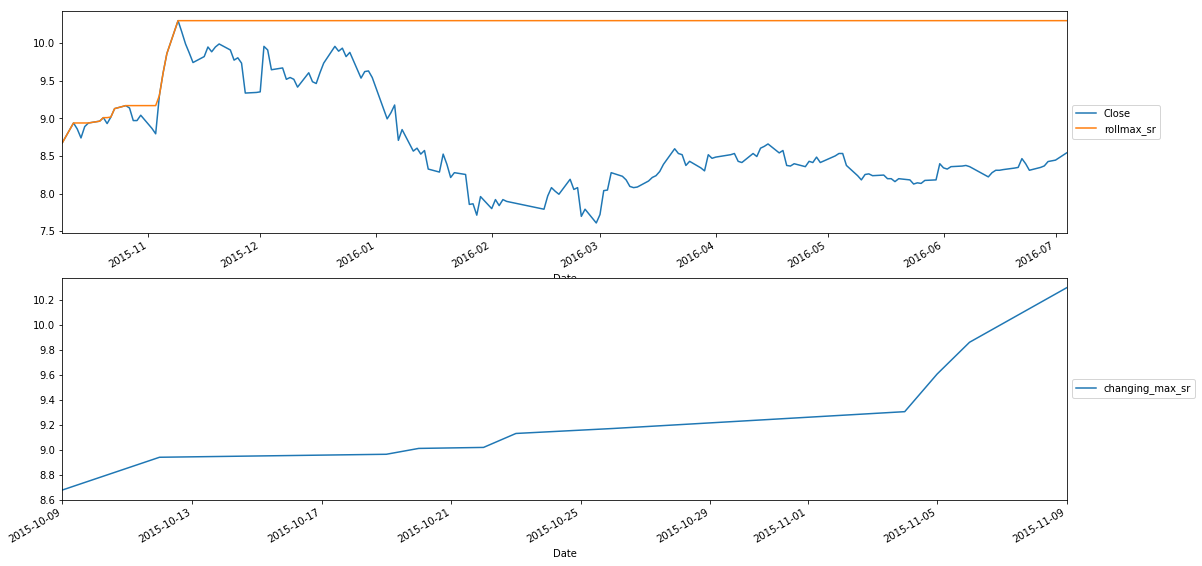

In [103]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10), #sharex=True
                      )
rate_sr.plot(ax=ax[0], ls='-', label='Close')
rollmax_sr.plot(ax=ax[0], ls='-', label='rollmax_sr')

changing_max_sr.plot(ax=ax[1], ls='-', label='changing_max_sr')

ax[0].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)
ax[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)
plt.show()

In [112]:
# Trail is either absolute number or series of absolute numbers
# To set trail in %, multiply % with rate_sr beforehand to get absolute numbers
def trailstop_exit(rate_sr, trail):
    #找到往后的最大值
    rollmax_sr = rate_sr.rolling(window=len(rate_sr.index), min_periods=1).max()
    if isinstance(trail, pd.Series):
        #每次最高价格出现变动的位置和价格
        changing_sr = rollmax_sr.iloc[rollmax_sr.pct_change().nonzero()]
        #变动的位置减去最大回撤后的价格
        stop_sr = (changing_sr - trail).reindex(rate_sr.index).ffill()
    else:
        #得到最大回撤，
        stop_sr = rollmax_sr - trail
    #找到所有价格低于这个最大回撤的位置
    is_below = np.where(rate_sr < stop_sr, 1, 0)
    #移动止损的位置
    sellstops = np.flatnonzero(is_below)
    #如果有止损位发送止损位置数据，如果没有返回None
    sellstop = sellstops[0] if len(sellstops) > 0 else None
    return sellstop



def depending(rate_sr, on_vector, signal_func, wait=0):
    """For each source signal generate a target signal (e.g., stop loss)"""

    idx = []
    #该函数输入一个矩阵，返回扁平化后矩阵中非零元素的位置（index）
    vector_idx = np.flatnonzero(on_vector)
    # Every two adjacent signals in the vector become a bin
    #制作每次买入点位到下个买入点位之间的记录
    bins = list(zip(vector_idx, np.append(vector_idx[1:], None)))
    for x, z in bins:
        x += wait
        # Apply signal function on the bin space only
        #两个买入点位的之间数据作为一个段, 得到具体的止损位置
        y = signal_func(rate_sr.iloc[x:z])
        #有止损发生
        if y is not None:
            idx.append(x + y)
            print("idx.append:", x + y)
    #重点标记止损位置
    return from_idx(len(rate_sr.index), idx)


In [121]:
# 测试 depending
#ma_entries
vector_idx = np.flatnonzero(ma_entries)
print(vector_idx)
x= np.append(vector_idx[1:], None)
print(x)
x = zip(vector_idx, np.append(vector_idx[1:], None))
print(x)
print(list(zip(vector_idx, np.append(vector_idx[1:], None))))

[ 16 113 177]
[113 177 None]
[(16, 113), (113, 177), (177, None)]


In [124]:
#价格，买点，止损
def trailstop_exits(rate_sr, entries, trail):
    return depending(rate_sr, entries, lambda sr: trailstop_exit(sr, trail))

In [127]:
#价格的 10%,设置诶最大回撤，设置止损
trailstop_exit_signals = trailstop_exits(rate_sr, ma_entries, 0.1 * rate_sr)

print(trailstop_exit_signals)

x: 16   y: 44
idx.append: 60
x: 113   y: None
x: 177   y: None
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead


In [128]:
print(ma_entries)
#flatnonzero 该函数输入一个矩阵，返回扁平化后矩阵中非零元素的位置（index）
vector_idx = np.flatnonzero(ma_entries)
print(vector_idx)
# 组合成分段list
bins = list(zip(vector_idx, np.append(vector_idx[1:], None)))
print(bins)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[ 16 113 177]
[(16, 113), (113, 177), (177, None)]


将MA退出策略与追踪止损相结合，并选择每个第一个退出序列。

In [130]:

def AND(v1, v2):
    """
        0 0 1 1 1 0
        0 1 1 1 0 0
    =   0 0 1 1 0 0
    """
    return v1 * v2


def OR(v1, v2):
    """
        0 0 1 1 1 0
        0 1 1 1 0 0
    =   0 1 1 1 1 0
    """
    return (v1 + v2 > 0).astype(int)


def XOR(v1, v2):
    """
        0 0 1 1 1 0
        0 1 1 1 0 0
    =   0 1 0 0 1 0
    """
    return (v1 - v2 != 0).astype(int)


def NOT(v):
    """
        0 1 1 1 1 0
    =   1 0 0 0 0 1
    """
    return ((v + 1) == 1).astype(int)


应用额外的过滤器，生成自己的位向量并使用vector.AND / OR / XOR运算。

In [131]:
#合并退出点位和 止损退出的点位
ma_exits = OR(ma_exits, trailstop_exit_signals)
#挑选最后的退出点位
ma_exits = first(ma_exits)

### 持仓 positions

In [149]:


def from_signals(rate_sr, entries, exits):
    """Generate positions from entry and exit bit-vectors"""
    # Merge
    merged = entries - exits - entries * exits
    nz_idx = np.flatnonzero(merged)
    if len(nz_idx) == 0:
        return pd.Series(0, index=rate_sr.index)
    #第一个位置添加0
    mask_first = merged[nz_idx] != np.insert(merged[nz_idx[:-1]], 0, 0)
    nz_idx = nz_idx[mask_first]
    # Always buy first
    if merged[nz_idx[0]] == -1:
        nz_idx = nz_idx[1:]
    return pd.Series(merged[nz_idx], index=rate_sr.index[nz_idx])


In [150]:
#ma_entries * ma_exits
#ma_entries - ma_exits 

merged = ma_entries - ma_exits - ma_entries * ma_exits
print(merged)
nz_idx = np.flatnonzero(merged)
print(nz_idx)
print("merged[nz_idx[:-1]]:", merged[nz_idx[:-1]])
print(np.insert(merged[nz_idx[:-1]], 0, 0))

mask_first = merged[nz_idx] != np.insert(merged[nz_idx[:-1]], 0, 0)
print("mask_first:",mask_first)
nz_idx = nz_idx[mask_first]
print("nz_idx:",nz_idx)

print(rate_sr.index[nz_idx])

[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
[  0  16  60 113 149 177]
merged[nz_idx[:-1]]: [-1  1 -1  1 -1]
[ 0 -1  1 -1  1 -1]
mask_first: [ True  True  True  True  True  True]
nz_idx: [  0  16  60 113 149 177]
DatetimeIndex(['2015-10-09', '2015-11-02', '2016-01-04', '2016-03-24',
               '2016-05-17', '2016-06-28'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [151]:
pos_sr = from_signals(rate_sr, ma_entries, ma_exits)
pos_sr.head()

Date
2015-11-02    1
2016-01-04   -1
2016-03-24    1
2016-05-17   -1
2016-06-28    1
dtype: int32

位置序列是二元系列，其中1 =变长，-1变短。 不会保留两个多头/空头头寸，因为我们想要一种干净的方式来评估策略（只有策略的逻辑必须对股权产生影响，而不是投资规模或其分布）



   count      mean       std    min     25%    50%     75%    max
0    3.0  0.041667  0.189964 -0.176 -0.0245  0.127  0.1505  0.174


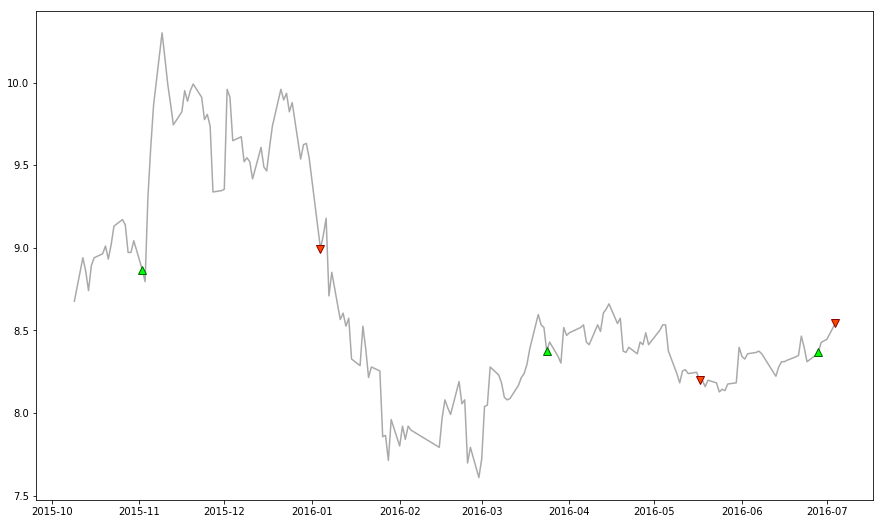

In [158]:


def positions_plot(rate_sr, pos_sr):
    bought = rate_sr.loc[pos_sr.index[0::2]]
    sold = rate_sr.loc[pos_sr.index[1::2]]
    if pos_sr.iloc[-1] == 1:
        sold.loc[rate_sr.index[-1]] = rate_sr.iloc[-1]
    stats = pd.Series((sold.values - bought.values)).describe()
    print(pd.DataFrame(stats).transpose())
    fig, ax = plt.subplots()

    ax.plot(rate_sr, c='darkgrey')

    # Draw position markers
    ax.plot(bought.index, bought, '^', color='lime',
            markeredgecolor='darkgreen', markersize=8, markeredgewidth=1)
    ax.plot(sold.index, sold, 'v', color='orangered',
            markeredgecolor='darkred', markersize=8, markeredgewidth=1)
    plt.show()

positions_plot(rate_sr, pos_sr)

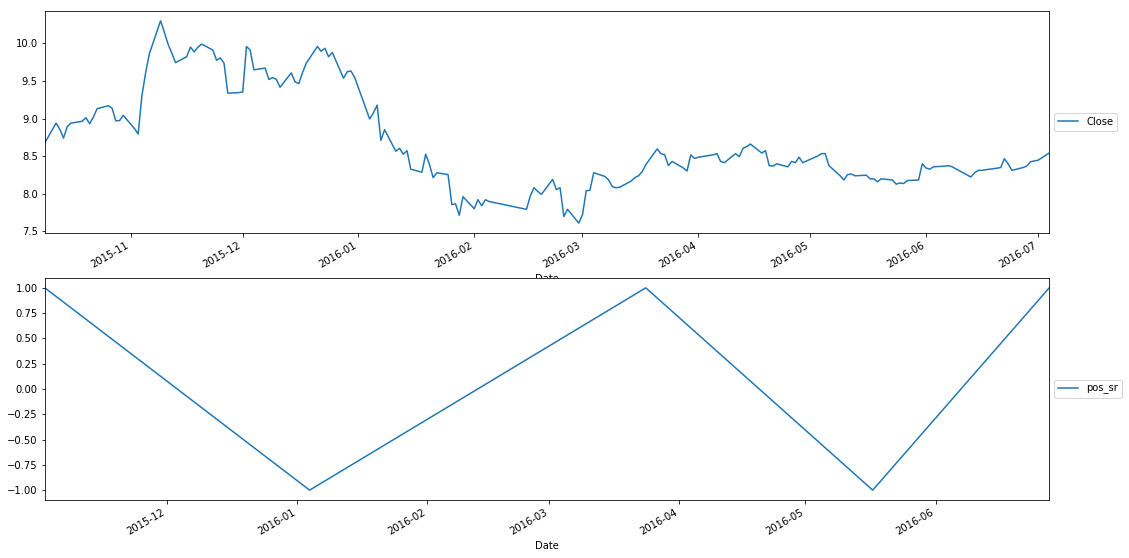

In [152]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10), #sharex=True
                      )
rate_sr.plot(ax=ax[0], ls='-', label='Close')
pos_sr.plot(ax=ax[1], ls='-', label='pos_sr')

ax[0].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)
ax[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)
plt.show()

### equity 资产价格

In [154]:

def pct_change(arr):
    # Percent change
    return np.insert(np.diff(arr) / arr[:-1], 0, 0)

def fshift(arr, n, fill):
    # Forward shift
    return np.concatenate([np.array([fill] * n), arr[:-n]], axis=0)


def ffill(arr):
    # Forward fill
    prev = np.arange(len(arr))
    prev[arr == 0] = 0
    prev = np.maximum.accumulate(prev)
    return arr[prev]

def from_positions(rate_sr, pos_sr, investment, fees, slippage):
    """
    Generate base equity from positions
    Initial purchase is exactly 1 (e.g., in BTC), fees and slippage covered
    """
    
    rates = rate_sr.values
    positions = pos_sr.reindex(rate_sr.index).fillna(0).values
    pos_idx = np.flatnonzero(positions)
    if len(pos_idx) == 0:
        return pd.Series(index=rate_sr.index)
    
    # Calculate returns
    returns_mask = ffill(positions)
    # Returns are always shifted by 1
    returns_mask = fshift(returns_mask, 1, 0)
    returns_mask = returns_mask == 1
    equity = np.ones(len(positions))
    equity[returns_mask] += pct_change(rates)[returns_mask]
    
    # Apply costs
    equity[pos_idx] *= 1 - fees
    if isinstance(slippage, pd.Series):
        equity[pos_idx] *= 1 - slippage.iloc[pos_idx].values
    else:
        equity[pos_idx] *= 1 - slippage
    
    # Apply investment
    if investment is None:
        investment = rates[0]
    equity = np.cumprod(equity) * investment
    
    # NaN before first position
    equity[:pos_idx[0]] = np.nan
    # Attach index
    return pd.Series(equity, index=rate_sr.index)



In [156]:
# Fees and slippage
investment = 1000
fees = 0.0025
slippage_factor = 0.25
slippage = (stock_code_daily_test['High'] - stock_code_daily_test['Low']) * slippage_factor / rate_sr
print(slippage)

Date
2015-10-09    0.005273
2015-10-12    0.010459
2015-10-13    0.003837
2015-10-14    0.004776
2015-10-15    0.005145
2015-10-16    0.003104
2015-10-19    0.004434
2015-10-20    0.004189
2015-10-21    0.012707
2015-10-22    0.004851
2015-10-23    0.004162
2015-10-26    0.008014
2015-10-27    0.006538
2015-10-28    0.005099
2015-10-29    0.002424
2015-10-30    0.003290
2015-11-02    0.004933
2015-11-03    0.004519
2015-11-04    0.013916
2015-11-05    0.021128
2015-11-06    0.009885
2015-11-09    0.017765
2015-11-10    0.009015
2015-11-11    0.007982
2015-11-12    0.007446
2015-11-13    0.005927
2015-11-16    0.006083
2015-11-17    0.006808
2015-11-18    0.007864
2015-11-19    0.003618
                ...   
2016-05-20    0.003385
2016-05-23    0.002169
2016-05-24    0.002184
2016-05-25    0.002180
2016-05-26    0.002458
2016-05-27    0.002416
2016-05-30    0.001925
2016-05-31    0.007323
2016-06-01    0.002607
2016-06-02    0.001441
2016-06-03    0.002632
2016-06-06    0.001882
2016-0

In [157]:

equity_sr = from_positions(rate_sr, pos_sr, investment, fees, slippage)
equity_sr

Date
2015-10-09            NaN
2015-10-12            NaN
2015-10-13            NaN
2015-10-14            NaN
2015-10-15            NaN
2015-10-16            NaN
2015-10-19            NaN
2015-10-20            NaN
2015-10-21            NaN
2015-10-22            NaN
2015-10-23            NaN
2015-10-26            NaN
2015-10-27            NaN
2015-10-28            NaN
2015-10-29            NaN
2015-10-30            NaN
2015-11-02     992.578865
2015-11-03     984.520038
2015-11-04    1041.603396
2015-11-05    1075.405699
2015-11-06    1103.947378
2015-11-09    1152.971909
2015-11-10    1136.070758
2015-11-11    1118.274181
2015-11-12    1104.842803
2015-11-13    1090.627927
2015-11-16    1099.470252
2015-11-17    1113.797055
2015-11-18    1106.633653
2015-11-19    1113.797055
                 ...     
2016-05-20     954.979587
2016-05-23     954.979587
2016-05-24     954.979587
2016-05-25     954.979587
2016-05-26     954.979587
2016-05-27     954.979587
2016-05-30     954.979587
2016-05

In [166]:
def to_quote(rate_sr, equity_sr):
    """Generate quote equity"""
    return equity_sr / rate_sr

# Linechart
###########

def plot_line(sr, benchmark=None):
    if benchmark is not None:
        print(pd.DataFrame((sr - benchmark).describe()).transpose())
    else:
        print(pd.DataFrame(sr.describe()).transpose())
    fig, ax = plt.subplots()

    ax.plot(sr, color='darkgrey')
    if benchmark is not None:
        if isinstance(benchmark, float) or isinstance(benchmark, int):
            pass
        else:
            ax.plot(benchmark, color='lightgrey')
        ax.fill_between(sr.index, sr, benchmark, where=sr > benchmark, facecolor='lime', interpolate=True)
        ax.fill_between(sr.index, sr, benchmark, where=sr < benchmark, facecolor='orangered', interpolate=True)
    ax.plot(sr.idxmax(), sr.max(), marker='x', markersize=10, color='black')
    ax.plot(sr.idxmin(), sr.min(), marker='x', markersize=10, color='black')
    plt.show()

def equity_plot(rate_sr, equity_sr):
    
    investment = equity_sr.bfill().iloc[0]
    hold_sr = (rate_sr.pct_change().fillna(0) + 1).cumprod() * investment
    print("base: equity - hold")
    plot_line(equity_sr, benchmark=hold_sr)
    print("quote: equity - hold")
    plot_line(to_quote(rate_sr, equity_sr), benchmark=to_quote(rate_sr, hold_sr))


base: equity - hold
   count       mean        std       min        25%        50%        75%  \
0  166.0  14.854766  36.383808 -63.50686 -23.162675  17.995205  24.154317   

          max  
0  115.974094  


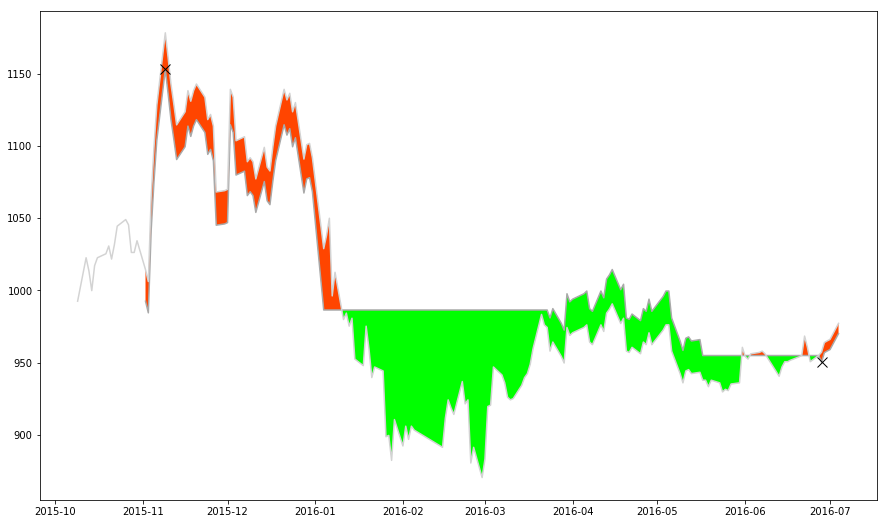

quote: equity - hold
   count     mean       std       min       25%      50%       75%        max
0  166.0  1.98246  4.412994 -6.918712 -2.463787  2.19706  2.956273  15.239697


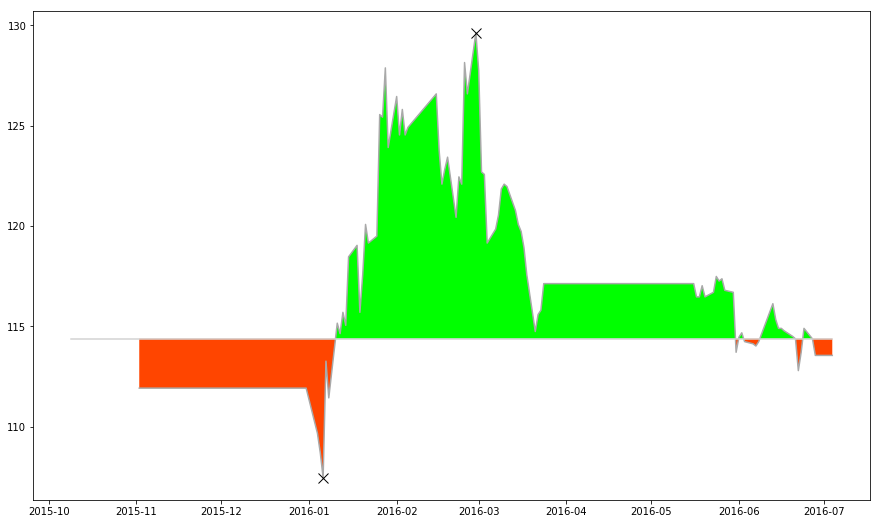

In [170]:
equity_plot(rate_sr, equity_sr)

### 回报

In [171]:
def from_equity(equity_sr):
    """Generate returns from equity"""
    return equity_sr.pct_change().fillna(0)



In [173]:
returns_sr = from_equity(equity_sr)
returns_sr

Date
2015-10-09    0.000000
2015-10-12    0.000000
2015-10-13    0.000000
2015-10-14    0.000000
2015-10-15    0.000000
2015-10-16    0.000000
2015-10-19    0.000000
2015-10-20    0.000000
2015-10-21    0.000000
2015-10-22    0.000000
2015-10-23    0.000000
2015-10-26    0.000000
2015-10-27    0.000000
2015-10-28    0.000000
2015-10-29    0.000000
2015-10-30    0.000000
2015-11-02    0.000000
2015-11-03   -0.008119
2015-11-04    0.057981
2015-11-05    0.032452
2015-11-06    0.026540
2015-11-09    0.044408
2015-11-10   -0.014659
2015-11-11   -0.015665
2015-11-12   -0.012011
2015-11-13   -0.012866
2015-11-16    0.008108
2015-11-17    0.013031
2015-11-18   -0.006432
2015-11-19    0.006473
                ...   
2016-05-20    0.000000
2016-05-23    0.000000
2016-05-24    0.000000
2016-05-25    0.000000
2016-05-26    0.000000
2016-05-27    0.000000
2016-05-30    0.000000
2016-05-31    0.000000
2016-06-01    0.000000
2016-06-02    0.000000
2016-06-03    0.000000
2016-06-06    0.000000
2016-0

   count      mean      std      min  25%  50%  75%       max
0  182.0 -0.000048  0.01248 -0.07662  0.0  0.0  0.0  0.064678


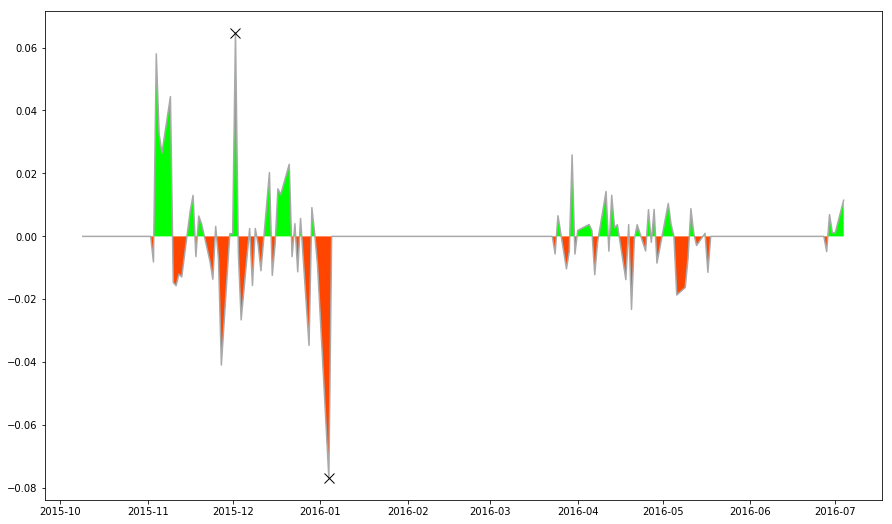

In [174]:
plot_line(returns_sr, benchmark=0)

### performance

In [182]:


def safe_divide(a, b):
    if b == 0:
        return np.nan
    return a / b



# Summary
#########

def summary(r):
    summary_sr = r.describe()
    summary_sr.index = pd.MultiIndex.from_tuples([('distribution', i) for i in summary_sr.index])

    summary_sr.loc[('performance', 'profit')] = profit(r)
    summary_sr.loc[('performance', 'avggain')] = avggain(r)
    summary_sr.loc[('performance', 'avgloss')] = avgloss(r)
    summary_sr.loc[('performance', 'winrate')] = winrate(r)
    summary_sr.loc[('performance', 'expectancy')] = expectancy(r)
    summary_sr.loc[('performance', 'maxdd')] = maxdd(r)

    summary_sr.loc[('risk/return profile', 'sharpe')] = sharpe(r)
    summary_sr.loc[('risk/return profile', 'sortino')] = sortino(r)

    return summary_sr


# Risk / return
###############

def sharpe(r, nperiods=None):
    res = safe_divide(r.mean(), r.std())
    if nperiods is not None:
        res *= (nperiods ** 0.5)
    return res


def sortino(r, nperiods=None):
    res = safe_divide(r.mean(), r[r < 0].std())
    if nperiods is not None:
        res *= (nperiods ** 0.5)
    return res



# Performance
#############

# Returns to equity
_e = lambda r: (r.replace(to_replace=np.nan, value=0) + 1).cumprod()

# Total earned/lost
_total = lambda e: e.iloc[-1] / e.iloc[0] - 1

trades = lambda r: (r != 0).sum().item()  # np.int64 to int
profits = lambda r: (r > 0).sum()
losses = lambda r: (r < 0).sum()
winrate = lambda r: safe_divide(profits(r), trades(r))
lossrate = lambda r: safe_divide(losses(r), trades(r))

profit = lambda r: _total(_e(r))
avggain = lambda r: r[r > 0].mean()
avgloss = lambda r: -r[r < 0].mean()
expectancy = lambda r: safe_divide(profit(r), trades(r))
maxdd = lambda r: 1 - (_e(r) / _e(r).expanding(min_periods=1).max()).min()


In [183]:
summary(returns_sr)

distribution         count         182.000000
                     mean           -0.000048
                     std             0.012480
                     min            -0.076620
                     25%             0.000000
                     50%             0.000000
                     75%             0.000000
                     max             0.064678
performance          profit         -0.022615
                     avggain         0.011429
                     avgloss         0.012479
                     winrate         0.517647
                     expectancy     -0.000266
                     maxdd           0.175719
risk/return profile  sharpe         -0.003860
                     sortino        -0.003628
dtype: float64

optimizer.gridsearch

In [193]:
import itertools
from timeit import default_timer as timer

import psutil

try:
    import _multiprocess as Pool
except ImportError:
    import _multiprocessing  as Pool

def my_map(func, params, multiprocess=False, processes=psutil.cpu_count() - 1):
    """Distribute map/starmap on # of processes (default to cores - 1)"""
    if not multiprocess:
        processes = 1
    print("cores: %d" % psutil.cpu_count())
    print("processes: %d" % processes)
    starmap = isinstance(params[0], tuple)
    print("starmap: %s" % starmap)
    t = timer()
    if starmap:
        func(*params[0])
    else:
        func(params[0])
    print("calcs: %d (~%.2fs) .." % (len(params), (timer() - t) * len(params) / processes))

    # Calculation
    t = timer()
    if processes > 1:
        with Pool(processes=processes) as pool:
            try:
                if starmap:
                    results = pool.starmap(func, params)
                else:
                    results = pool.map(func, params)
            except Exception as e:
                pool.close()
                pool.join()
                raise e
    else:
        if starmap:
            results = [func(*p) for p in params]
        else:
            results = [func(p) for p in params]

    print("done. %.2fs" % (timer() - t))
    return results


In [196]:

def range_params(min_param, max_param, step):
    """Simple range"""
    return np.arange(min_param, max_param + step, step)

def EMA(rate_sr, *args, **kwargs):
    return rate_sr.ewm(*args, **kwargs).mean()

def from_func(func, params, multiprocess=False):
    """Build a list of tuples out of parameter combinations and function outputs"""
    
    # CAUTION: Multiprocessing only slows down generation of large series
    return dict(zip(params, my_map(func, params, multiprocess=multiprocess)))


ma_func = lambda span: EMA(rate_sr, span=span)
min_ma, max_ma, step = 1, 100, 1
fees = 0.0025

# Cache moving averages
param_range = range_params(min_ma, max_ma, step)
ma_cache = dict(from_func(ma_func, param_range))
print(param_range)
print(ma_cache)

cores: 4
processes: 1
starmap: False
calcs: 100 (~0.08s) ..
done. 0.05s
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
{1: Date
2015-10-09     8.677
2015-10-12     8.940
2015-10-13     8.860
2015-10-14     8.741
2015-10-15     8.892
2015-10-16     8.940
2015-10-19     8.964
2015-10-20     9.011
2015-10-21     8.932
2015-10-22     9.019
2015-10-23     9.131
2015-10-26     9.171
2015-10-27     9.139
2015-10-28     8.972
2015-10-29     8.972
2015-10-30     9.043
2015-11-02     8.868
2015-11-03     8.796
2015-11-04     9.306
2015-11-05     9.608
2015-11-06     9.863
2015-11-09    10.301
2015-11-10    10.150
2015-11-11     9.991
2015-11-

 For each MA combination, generate position series.

In [202]:

def above(rate_sr, benchmark_sr):
    """Rate above benchmark"""
    return np.where(rate_sr > benchmark_sr, 1, 0)


def below(rate_sr, benchmark_sr):
    return np.where(rate_sr < benchmark_sr, 1, 0)

# Dual MA Crossover
###################

def DMAC_entries(fast_ma_sr, slow_ma_sr):
    """Entry once fast MA over slow MA (or band)"""
    return above(fast_ma_sr, slow_ma_sr)


def DMAC_exits(fast_ma_sr, slow_ma_sr):
    return below(fast_ma_sr, slow_ma_sr)


def combine_rep_params(min_param, max_param, step, dims):
    """AA AB AC BB BC CC"""
    arange = range_params(min_param, max_param, step)
    return list(itertools.combinations_with_replacement(arange, dims))


# Params
ma_space = combine_rep_params(min_ma, max_ma, step, 2)

# Func
def ma_positions_func(fast_ma, slow_ma):
    # Cache
    fast_ma_sr = ma_cache[fast_ma]
    slow_ma_sr = ma_cache[slow_ma]
    # Signals
    entries = DMAC_entries(fast_ma_sr, slow_ma_sr)
    entries =first(entries)
    exits = DMAC_exits(fast_ma_sr, slow_ma_sr)
    exits = first(exits)
    # Positions
    pos_sr = from_signals(rate_sr, entries, exits)
    return pos_sr

In [203]:
ma_positions_srmap = from_func(ma_positions_func, ma_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~13.00s) ..
done. 4.49s


In [ ]:
3. For each position series, generate returns series.

In [204]:
def ma_returns_func(fast_ma, slow_ma):
    # Equity
    pos_sr = ma_positions_srmap[(fast_ma, slow_ma)]
    equity_sr = from_positions(rate_sr, pos_sr, investment, fees, slippage)
    # Returns
    returns_sr = from_equity(equity_sr)
    return returns_sr

In [206]:
ma_returns_srmap = from_func(ma_returns_func, ma_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~9.81s) ..
done. 8.23s


In [ ]:
For each MA window combination generate random positions of same length and resulting returns.

In [208]:

def random(rate_sr, n):
    """Generate random positions"""
    import random

    if n == 0:
        return pd.Series()
    idx = sorted(random.sample(range(len(rate_sr.index)), n))
    positions = pd.Series(index=rate_sr.index[idx])
    positions.iloc[0::2] = 1
    if n > 1:
        positions.iloc[1::2] = -1
    return positions

# Params
random_space = [(fma, sma, len(np.flatnonzero(ma_positions_srmap[(fma, sma)].values))) for fma, sma in ma_space]

# Func
def random_returns_func(slow_ma, fast_ma, n):
    # Positions
    pos_sr = random(rate_sr, n)
    # Equity
    equity_sr = from_positions(rate_sr, pos_sr, investment, fees, slippage)
    # Returns
    returns_sr = from_equity(equity_sr)
    return returns_sr

In [209]:
random_returns_srmap = from_func(random_returns_func, random_space)


cores: 4
processes: 1
starmap: True
calcs: 5050 (~25.83s) ..
done. 11.09s


nummap